In [54]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd
from torch.optim.lr_scheduler import StepLR

class LSTMWithLinearAdd(nn.Module):
    def __init__(self, input_size, hidden_size, num_linear_out ,num_layers=2, dropout=0.1):
        super(LSTMWithLinearAdd, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=dropout)
        self.lstm_out = nn.Linear(hidden_size, num_linear_out)
        self.linear = nn.Linear(num_linear_out, 1)
        self.regression = nn.Linear(input_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_lstm = lstm_out[:, -1, :]
        lstm_pred = self.lstm_out(last_lstm)        
        linear_pred = self.linear(lstm_pred)
        sensitivity = self.regression (x[:, -1, :])

        return linear_pred+sensitivity

In [55]:
def train_model(model, dataloader, num_epochs, lr=1e-3):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # Define a learning rate scheduler
    scheduler = StepLR(optimizer, step_size=50, gamma=0.5)  # Reduce LR by 10x every 10 epochs

    criterion = nn.MSELoss()

    for epoch in range(num_epochs):
        total_loss = 0
        for X, y in dataloader:
            optimizer.zero_grad()
            pred = model(X)
            loss = criterion(pred.squeeze(), y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            # Step the scheduler
        scheduler.step()
        current_lr = scheduler.get_last_lr()[0]
        if current_lr< 1e-6:
            print("Learning rate too low, stopping training.")
            break

        # Print the current learning rate
        current_lr = scheduler.get_last_lr()[0]
        print(f"Epoch {epoch+1}/{num_epochs}, Batch Loss: {loss.item():.4f}, Learning Rate: {current_lr:.6f}")

        

In [56]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch
from torch.utils.data import Dataset

class NormalizedTimeSeriesDataset(Dataset):
    def __init__(self, series, target, window_size, scaler=None):
        # series: (n_samples, n_features)
        # target: (n_samples,)
        # Handle missing values: fill NaNs with last valid value (forward fill)
        df = np.where(np.isnan(series), np.nan, series)
        for i in range(series.shape[1]):
            col = df[:, i]
            isnan = np.isnan(col)
            col[isnan] = np.interp(np.flatnonzero(isnan), np.flatnonzero(~isnan), col[~isnan])
            df[:, i] = col
        series = df

        # Normalize input features
        self.scaler = scaler if scaler else StandardScaler()
        self.series = self.scaler.fit_transform(series) if not scaler else self.scaler.transform(series)

        # Target normalization (optional)
        self.target_mean = np.mean(target)
        self.target_std = np.std(target)
        self.target = (target - self.target_mean) / self.target_std

        self.X = []
        self.y = []
        for i in range(len(series) - window_size):
            self.X.append(self.series[i:i + window_size])
            self.y.append(self.target[i + window_size])

        self.X = torch.tensor(np.stack(self.X), dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

    def inverse_target(self, y_tensor):
        return y_tensor.detach().cpu().numpy() * self.target_std + self.target_mean

In [57]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, target, window_size):
        self.window_size = window_size
        self.X = []
        self.y = []

        for i in range(len(data) - window_size):
            self.X.append(data[i:i + window_size])  # input sequence
            self.y.append(target[i + window_size])  # target value

        self.X = torch.tensor(self.X, dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]
    def inverse_target(self, y_tensor):
        return y_tensor.detach().cpu().numpy()

In [65]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

window = 180
sp500 = pd.read_csv('../data/Eq.csv',delimiter=',',index_col=0)# Load your dataset here


sp500 = np.log(sp500 / sp500.shift(1))  # Apply log returns transformation

sp500 = sp500.dropna()  # Drop NaN values

# Replace 'NaN' with 0
# Replace 0 with NaN
n = sp500.shape[0]
features = sp500.shape[1]  # Assuming the first column is the date
data= sp500.values[:, :].astype(float) # Assuming the first column is the date


target_series = data[:,0]  # Use returns as the target series
# Assuming `data` is your feature matrix and `target_series` is your target variable
n_samples = len(data)
train_size = int(0.8 * n_samples)  # First 80% for training

# Split the data
X_train, X_test = data[:train_size], data[train_size:]
y_train, y_test = target_series[:train_size], target_series[train_size:]

# Create normalized datasets for training and testing
train_dataset = NormalizedTimeSeriesDataset(X_train, y_train, window_size=window)
test_dataset = NormalizedTimeSeriesDataset(X_test, y_test, window_size=window,scaler=train_dataset.scaler)

# Create DataLoaders for training and testing
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
# Train model
model = LSTMWithLinearAdd(input_size=features, hidden_size=32, num_linear_out=8, num_layers=3, dropout=0.0)
train_model(model, train_dataloader, num_epochs=50, lr=1e-2)




Epoch 1/50, Batch Loss: 2.2080, Learning Rate: 0.010000
Epoch 2/50, Batch Loss: 2.2127, Learning Rate: 0.010000
Epoch 3/50, Batch Loss: 2.2223, Learning Rate: 0.010000
Epoch 4/50, Batch Loss: 2.2187, Learning Rate: 0.010000
Epoch 5/50, Batch Loss: 2.1691, Learning Rate: 0.010000
Epoch 6/50, Batch Loss: 2.0987, Learning Rate: 0.010000
Epoch 7/50, Batch Loss: 1.8047, Learning Rate: 0.010000
Epoch 8/50, Batch Loss: 1.8878, Learning Rate: 0.010000
Epoch 9/50, Batch Loss: 1.8884, Learning Rate: 0.010000
Epoch 10/50, Batch Loss: 1.6832, Learning Rate: 0.010000
Epoch 11/50, Batch Loss: 1.5470, Learning Rate: 0.010000
Epoch 12/50, Batch Loss: 1.7897, Learning Rate: 0.010000
Epoch 13/50, Batch Loss: 1.5224, Learning Rate: 0.010000
Epoch 14/50, Batch Loss: 1.5709, Learning Rate: 0.010000
Epoch 15/50, Batch Loss: 1.4521, Learning Rate: 0.010000
Epoch 16/50, Batch Loss: 1.3356, Learning Rate: 0.010000
Epoch 17/50, Batch Loss: 1.3673, Learning Rate: 0.010000
Epoch 18/50, Batch Loss: 1.1930, Learnin

Hit rate:  0.625


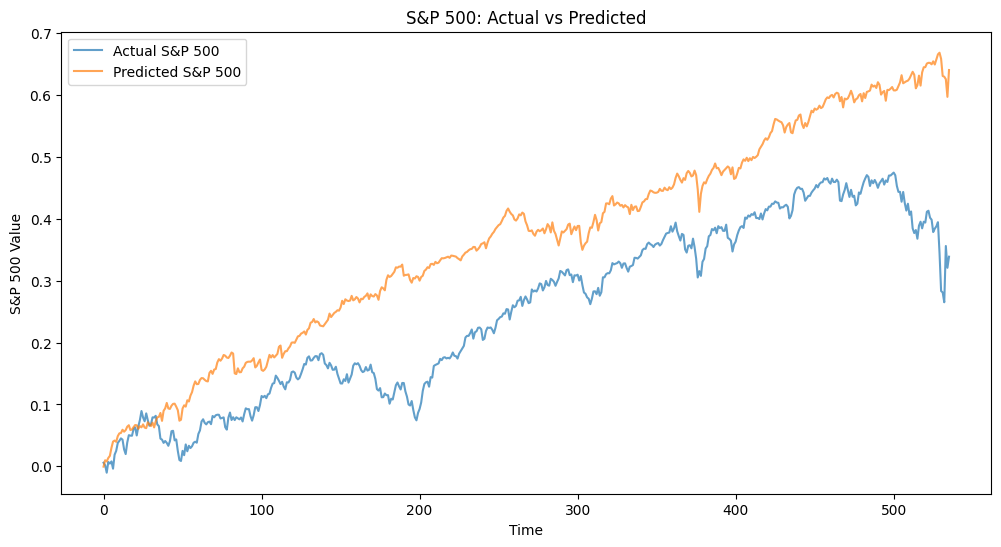

In [66]:
# Get predictions from the model
model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for X, y in test_dataloader:
        pred = model(X).squeeze()
        predictions.extend(test_dataset.inverse_target(pred))
        actuals.extend(test_dataset.inverse_target(y))
        
        
actuals =  np.array(actuals).flatten()
sactuals = np.cumsum(actuals[:])  # Perform cumulative sum on actuals
predictions= np.array(predictions).flatten()
spredictions = np.cumsum(predictions[:])  # Take the last 20 samples

hitrate = sactuals%predictions
prob = hitrate[hitrate>0]
print("Hit rate: ", len(prob)/len(hitrate))


# Ensure both lists are the same length
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot((sactuals), label="Actual S&P 500", alpha=0.7)
plt.plot((spredictions), label="Predicted S&P 500", alpha=0.7)
plt.title("S&P 500: Actual vs Predicted")
plt.xlabel("Time")
plt.ylabel("S&P 500 Value")
plt.legend()